# 1. Introduction: goal of our analysis

* Bombini Nicola 5106823
* Iania Leonardo 5109216

Starting from the same [Face dataset](https://susanqq.github.io/UTKFace/), we focused also on age regression, using a sequential neural network containing convolutional layers which gives as output a scalar.

In pursuing our goal, we used Pytorch and d2l APIs and the project is based on the Deep Learning course taught from professor Jianyi Lin @ Università Cattolica del Sacro Cuore in Milan.

The original dataset is made of 23708 pictures of people in the age range 0-116.

In [ ]:
%%capture 
# libraries
!pip install d2l==1.0.0a1.post0
!pip install split-folders

import os, os.path, shutil
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
from google.colab import drive
drive.mount('/content/drive')
d2l.use_svg_display()
sns.set_theme();
%matplotlib inline

# 2. Data Exploration

## 2.1. Data Reading

First of all we import our data to the environment:

In [ ]:
%%capture 
# data reading and group splitting

!tar -xzvf "/content/drive/MyDrive/progetto_dl/Dire.tar.gz" -C "/content/"  # UnTar data

folder_path = "/content/Dire/UTKFace/" # define the path for reading

images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

## 2.2. Pictures

To better understand the data we are dealing with, we can plot some pictures with people of different ages:

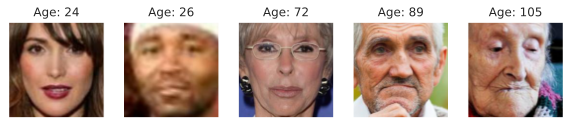

In [ ]:
# find 5 different ages and plot them:

# Here we need to find different ages file names
all_ages, alf, omeg = list(range(110)), 0 , 26
check_l = all_ages[alf:omeg]
count = 0
to_plot = []
while count < 4:
  for i in range(len(images)):
    age = images[i].split('_')[0]
    if int(age) in check_l:
      to_plot.append(images[i])
      alf += 26
      omeg += 26
      check_l = all_ages[alf:omeg]
      count += 1 

# in to_plot we have 5 different file names for 5 people, each one from a different
# age group
sns.set_theme()
plt.figure(figsize=(10,15))
for i in range(len(to_plot)):
  plt.subplot(1,5,i+1)
  image = imread('/content/Dire/UTKFace/'+to_plot[i])
  titolo_age = to_plot[i].split('_')[0]
  plt.title(f'Age: {titolo_age}')
  #empty x and y ticks to avoid overlapping pictures with axis: 
  plt.xticks([]) 
  plt.yticks([])
  plt.imshow(image)

## 2.3. Distribution

Another important information that must be considered is the age distribution, which can have a very relevant effect on the performance of the model in generalization ability. Let's plot the histogram and the estimated density curve: 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


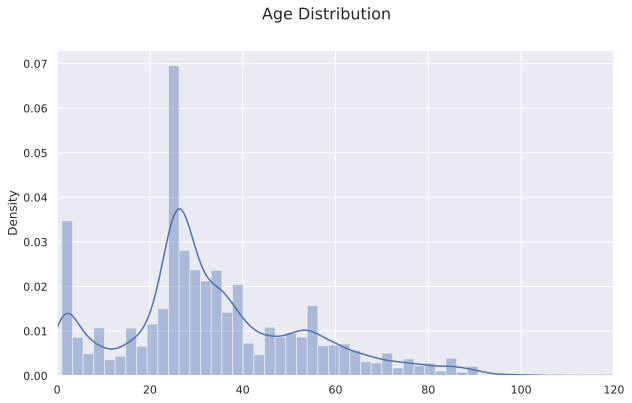

In [ ]:
# hist
distr_age = [] # will contain each age present in our dataset
for i in range(len(images)):
  distr_age.append(int(images[i].split('_')[0]))

sns.set_theme()
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(distr_age, kde=True, ax=ax)
fig.suptitle('Age Distribution', fontsize=16)
ax.set_xlim(0, 120)
plt.show();

## 2.4. Statistics of the distribution



Of course, we also need to inspect the main statistics of the age distribution:

In [ ]:
# max,min,mean,sd age table
table = [['Max',max(distr_age)],
         ['Min',min(distr_age)],
         ['Mean',round(np.average(distr_age),2)],
         ['SD',round(np.std(distr_age),2)]
         ]
print(tabulate(table, tablefmt='fancy_grid'))

╒══════╤════════╕
│ Max  │ 116    │
├──────┼────────┤
│ Min  │   1    │
├──────┼────────┤
│ Mean │  33.3  │
├──────┼────────┤
│ SD   │  19.89 │
╘══════╧════════╛


And a useful information is represented also by the percentiles:

In [ ]:
table_percentiles = [['25%',np.percentile(distr_age,25)],
         ['50%',np.percentile(distr_age,50)],
         ['75%',np.percentile(distr_age,75)]]
print(tabulate(table_percentiles, tablefmt='fancy_grid'))

╒═════╤════╕
│ 25% │ 23 │
├─────┼────┤
│ 50% │ 29 │
├─────┼────┤
│ 75% │ 45 │
╘═════╧════╛


As expected, the distribution is skewed. Moreover, we can investigate on how many observations we have for ages greater than 100 years old:

In [ ]:
greater_100 = [i for i in distr_age if i > 99]
len(greater_100)

32

In [ ]:
filtered = []

for age in distr_age:
    if age <= 99:
        filtered.append(age)

In [ ]:
print(f'{round((len(greater_100)/len(distr_age))*100,3)} %')

0.135 %


There are only 32 pictures for people with age above 100, hence we decided to take them away, since the represent just the 0.1% of the dataset. Here below, the distribution of the final dataset that we are working with:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


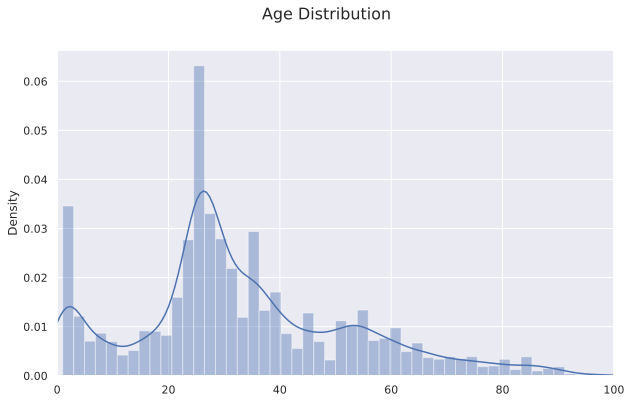

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(filtered, kde=True, ax=ax)
fig.suptitle('Age Distribution', fontsize=16)
ax.set_xlim(0, 100)
plt.show()

# 3. Modeling

## 3.1. Data preparation

To prepare our data for modeling, we apply the same transformation we used in the ethnicity classification part, with a resize to 80x80:

In [ ]:
data_augmentation = transforms.Compose([
        transforms.Resize(80),
        transforms.ToTensor(),
    ])

X_2 = []
eta_2 = []
an2=[f for f in range(0,100)]


for i in range(len(images)):
  if int(images[i].split('_')[0]) in an2:
    eta_2.append(int(images[i].split('_')[0]))
    img = Image.open(folder_path+images[i])
    t1 = data_augmentation(img)
    X_2.append(t1)
  

We then split our data into train, validation and test sets:

In [ ]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X_2, eta_2, test_size=0.2)
xtrain2, xval2, ytrain2, yval2 = train_test_split(xtrain2, ytrain2, test_size=0.2)

We are now ready to start the actual modeling

## 3.2. Model Training

We start by defining the number of epochs to train our model, and the dimension of the batches that we will use in training:

In [ ]:
num_epochs = 36

batch_size = 128

We then define our network, which we designed to be an alternance between 2 convolutional layers and 2 average pooling layers, followed by a fully connected part. We took inspiration from the LeNet architecture, with some little changes: 
* First of all, the input channels are 3 and not 1, since we are working with RGB pictures
* We decided to use the ReLU activation function instead of the Sigmoid one, since first of all there is a computational saving, and then to reduce the probability of having a vanishing gradient
* We added some Linear layers to the fully connected part after the Flattening layer, since a reduction in a single layer from 5184 to 120 elements, would make us lose information
* We decided to use as numbers of outputs powers of 2, to make the computation faster
* We added some Linear layers also at the end of the fully connected part, since by doing a regression, we need just one value, differently from a classification problem with the number of categories (with a Softmax at the end), hence a direct reduction from 84 to 1 elements, would make us lose information

In [ ]:
retest2 = nn.Sequential( 
    # No need for Reshape()
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(),  
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), 
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(5184, 512), nn.ReLU(),  
    nn.Linear(512, 128), nn.ReLU(),  
    nn.Linear(128, 84), nn.ReLU(), 
    nn.Linear(84, 32), nn.ReLU(),
    nn.Linear(32,1))

We used once again the Adam optimizer:

In [ ]:
trainer2 = torch.optim.Adam(retest2.parameters(), lr = 0.01)

Since we are dealing with a regression problem, we decided to use the MSE as loss metric, to see whether the predicted value would actually be close to the true one. A problem that arised from this choice, was that the network tended to predict the average age, that by being in the middle of the distribution, naturally reduced this metric. At the end, we were able to avoid this problem by fining the network, which after some epochs better understands the data and instead of always proposing us the mean, starts making considerably better predictions, as you will see later:

In [ ]:
loss2 = nn.MSELoss()

Given the said problem, we decided to add a more reliable metric to see in real time the progress of the training, and whether our network was actually learning or not. We opted for the percentiles of the values predicted, to see if their distribution was realistic, which meant that the network was not just predicting the mean everytime. To have a direct representation of this, we decide to also take a look at the difference between the predicted percentiles and the actual ones.

Given the lack of reliable metrics to use to track the training evolution, we implemented a custom **early stopping**, based on the sum of the absolute values of difference between the percentiles of the distribution of the predicted values and the ones of the validation set.

After different attempts, we decided to set the threshold of this value to be 11. That is, if this sum is less than that value, the training ends.

This means of course that we're losing the possibility to reduce more the distance from the real set, but this will also help us to avoid overfitting and dispersion during the train - or the problem of always predicting the mean, introduced above.

We then started with our training: 

In [ ]:
dim_img=80

In [ ]:
list_val_loss=[] # will contain the validation loss at each epoch
tr_percentiles_true = [['25%',np.percentile(ytrain2,25)],
         ['50%',np.percentile(ytrain2,50)],
         ['75%',np.percentile(ytrain2,75)],
         ['95%',np.percentile(ytrain2,95)]]

val_percentiles_true = [['25%',np.percentile(yval2,25)],
         ['50%',np.percentile(yval2,50)],
         ['75%',np.percentile(yval2,75)],
         ['95%',np.percentile(yval2,95)]]

print(f' train percentiles TRUE : {tr_percentiles_true}')
print(f' val percentiles TRUE: {val_percentiles_true}')

for epoch in range(num_epochs):
  # a and b will guide the slicing of the dataset in different batches.
  a = 0
  b = 128
  batch_size = b-a # used for last batch - of course will be less than 128
  
  # convert tensor and their shape to feed the network
  y = torch.FloatTensor(ytrain2)
  X_t = torch.cat(xtrain2).reshape(len(xtrain2),3,dim_img,dim_img)

  while a <= len(xtrain2) and a<b:
    # we need to reshape to feed the network
    X_batched = X_t[a:b]
    X_batched = X_batched.reshape(batch_size,3,dim_img,dim_img)
    y_batched = y[a:b].reshape(batch_size,1)

    # X_batched will be made of 128 tensor 3x80x80

    # prediction
    y_hat = retest2(X_batched)

    # loss and backward propagation
    l_b2 = loss2(y_hat,y_batched)
    trainer2.zero_grad()
    l_b2.backward()
    trainer2.step()
    
    # update a and b for next slicing (next batch)
    a += 128
    b += 128

    # here we need to take into account the last batch that will be smaller than 128 
    # due to the fact that the train set dimension is not a multiple of 128
    if b < len(xtrain2):
      b = b
      batch_size = 128
    else:
      b = len(xtrain2)
      batch_size = b-a

  
  # epoch loss
  l_b2 = loss2(y.reshape(len(xtrain2),1),retest2(X_t.reshape(len(xtrain2),3,dim_img,dim_img)))

  # validation:
  valtensor2 = torch.cat(xval2)
  valtensor2 = valtensor2.reshape(len(yval2),3,dim_img,dim_img)
  val_hat2=retest2(valtensor2)
  y_valt2 = torch.FloatTensor(yval2)
  y_valt2 = y_valt2.reshape(len(yval2),1)
  val_loss2 = loss2(y_valt2,val_hat2)

 
  list_val_loss.append(round(float(val_loss2),2))
  print(f' \n --- EPOCH: {epoch+1} - train loss (MSE): {l_b2} - validation loss (MSE): {list_val_loss[epoch]}')
  print('-'*180)
  
  train_ages = y_hat.tolist()
  val_ages = val_hat2.tolist()

  
  tr_percentiles_pred = [['25%',np.percentile(train_ages,25)],
         ['50%',np.percentile(train_ages,50)],
         ['75%',np.percentile(train_ages,75)],
         ['95%',np.percentile(train_ages,95)]]

 
  val_percentiles_pred = [['25%',np.percentile(val_ages,25)],
         ['50%',np.percentile(val_ages,50)],
         ['75%',np.percentile(val_ages,75)],
         ['95%',np.percentile(val_ages,95)]]
      
  diff_percentiles_val = [
    [val_percentiles_pred[0][0],val_percentiles_pred[0][1]-val_percentiles_true[0][1]],
    [val_percentiles_pred[1][0],val_percentiles_pred[1][1]-val_percentiles_true[1][1]],
    [val_percentiles_pred[2][0],val_percentiles_pred[2][1]-val_percentiles_true[2][1]],
    [val_percentiles_pred[3][0],val_percentiles_pred[3][1]-val_percentiles_true[3][1]]]


  print(f' train percentiles predicted : {tr_percentiles_pred}')
  print('-'*180)
  print(f' val percentiles predicted: {val_percentiles_pred}')
  print('-'*180)
  print(f' Difference pred - true percentiles: {diff_percentiles_val}')
  print('-'*180)

  # early stopping:

    # compute the early stopping metric:
  abs_diff_perc = abs(diff_percentiles_val[0][1])+abs(diff_percentiles_val[1][1])+abs(diff_percentiles_val[2][1])+abs(diff_percentiles_val[3][1])
    # comparison with the threshold value:
  if abs_diff_perc <= 11:
    break

  

 train percentiles TRUE : [['25%', 23.0], ['50%', 29.0], ['75%', 45.0], ['95%', 71.0]]
 val percentiles TRUE: [['25%', 23.0], ['50%', 29.0], ['75%', 45.0], ['95%', 72.0]]
 
 --- EPOCH: 1 - train loss (MSE): 393.86798095703125 - validation loss (MSE): 389.89
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 train percentiles predicted : [['25%', 34.5692024230957], ['50%', 34.5692024230957], ['75%', 34.5692024230957], ['95%', 34.5692024230957]]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 val percentiles predicted: [['25%', 34.48793029785156], ['50%', 34.48793029785156], ['75%', 34.48793029785156], ['95%', 34.48793029785156]]
---------------------------------------------------------------------------------------------------

There are surely some things to highlight from these results:
* First of all, it's now graphically clear why the MSE loss alone, is an unreliable metric. As you can see, the best predictions don't coincide with the lowest MSE values, highliting what was said above
* The training ends when the sum of the absolute values of the difference of percentiles is less than or equal to 11.

## 3.3. Model Evaluation

Passing to testing, we firstly wanted to have a glance to the RMSE, the square root of the loss metric we used in the model, which practically represents the difference in actual years between our predictions and the test values:

In [ ]:
test2tensor = torch.cat(xtest2)
test2tensor = test2tensor.reshape(len(xtest2),3,dim_img,dim_img)
test2_pred=retest2(test2tensor)
  
y_true2 = torch.FloatTensor(ytest2)
y_true2 = y_true2.reshape(len(xtest2),1)

test2_mse = loss2(test2_pred,y_true2)
test2_mse = round(float(test2_mse),3)
test2_rmse = np.sqrt(test2_mse)
print(f'the MSE is: {test2_mse}')
print(f'and so the RMSE is: {round(test2_rmse,3)}')

the MSE is: 116.582
and so the RMSE is: 10.797


We obtain an average difference of around 11 years, which given the vast range of ages inspected, is objectively good. It's then surely useful to see grafically the distribution of the predictions, and to compare it with the actual one:

In [ ]:
test_ages = test2_pred.tolist()
print(min(test_ages))
print(max(test_ages))

[1.991103172302246]
[119.36945343017578]


From the first glance at the data that we can take above, we can see that the maximum and minimum ages predicted, are surely coherent with the true values, which is a good indicator. Passing onto the plots:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


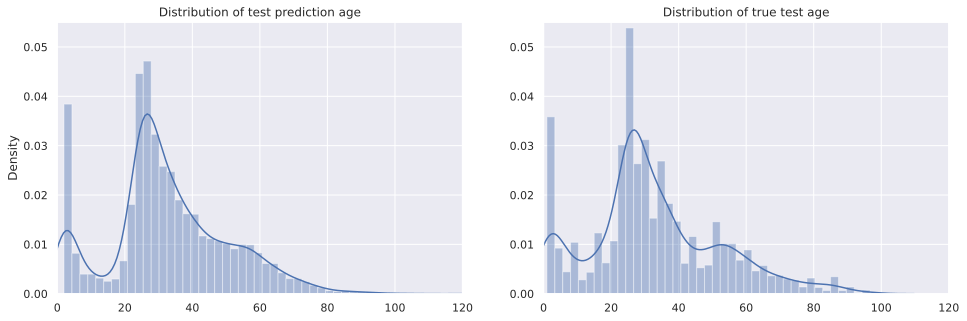

In [ ]:
test_ages_true = y_true2.tolist()
sns.set_theme();
fig, axs = plt.subplots(1, 2,figsize=(16,5))
sns.distplot(test_ages, kde=True, ax=axs[0]);
axs[0].set_title('Distribution of test prediction age', fontsize=12);
axs[0].set_xlim(0, 120);
axs[0].set_ylim(0, 0.055);
sns.distplot(test_ages_true, kde=True, ax=axs[1]);
axs[1].set_title('Distribution of true test age', fontsize=12);
axs[1].set_xlim(0, 120);
axs[1].set_ylabel('');
axs[1].set_ylim(0, 0.055)
plt.show();

It's clear from the distributions that we have realistic predictions, as we could understand by the training metrics.

## 3.4. Graphical evaluation

It's then very interesting to actually view the pictures from the test, and to evaluate, besides the pure numbers, how good were the predictions:

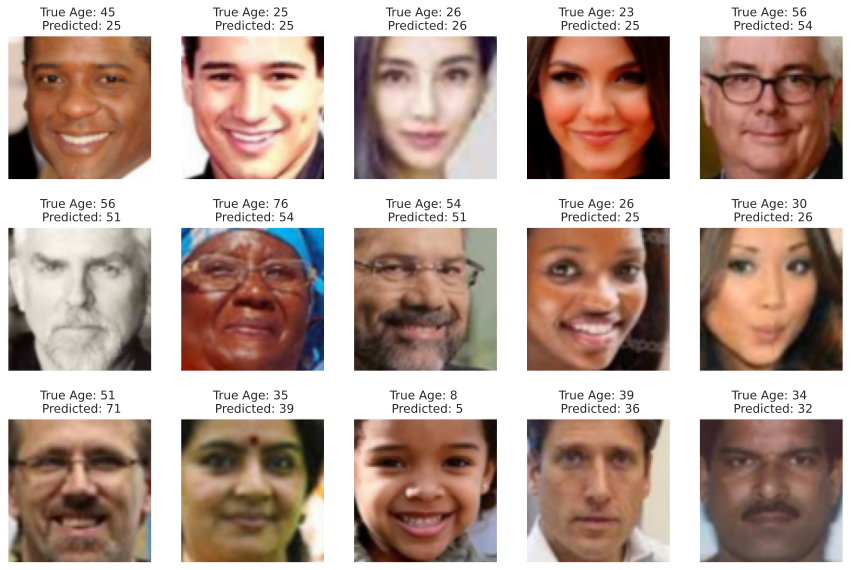

In [ ]:
np.random.seed(9)
toplot = np.random.randint(0,len(xtest2),15)
plt.figure(figsize=(15,10))
count=1
for i in toplot:
  plt.subplot(3,5,count)
  im = transforms.ToPILImage()(xtest2[i]).convert("RGB")
  plt.imshow(im)
  plt.title(f'True Age: {ytest2[i]} \n Predicted: {int(test2_pred[i])}')
  plt.xticks([]) 
  plt.yticks([])
  count+=1

plt.show()

# 4. Conclusion

The deep regression starting from images is, in this moment, a very challenging task for the deep learning community. For various aspects, we're not able to reach, generally speaking, results higher as the classification case. However, monitoring different metrics we managed to achieve a result above our expectations.


Moreover, asking to different people we know to predict the age of the 15 subjects showed above, in about 50% of the cases our network beat them, predicting values closer than the humans in absolute difference terms.
The result is impressive if we think that our friends have been trained for years, while our network only for some hours.